<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Predictive Analytics (QBUS2820)</h1></center>
<center><h2>Tutorial 11: Forecasting</h2></center>
<br>

This tutorial we study the practical application of basic forecasting methods in Python. Exponential smoothing is not available in any standard Python package, so that they are coded on the <TT>forecast.py</TT> file, which you need to download from Blackboard. 


<a class="buttom" href=">#Data:-Australian-CPI-Inflation">Data: Australian CPI inflation</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Random-Walk">Random Walk</a> <br>
<a class="buttom" href="#Simple-Exponential-Smoothing">Simple Exponential Smoothing</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Australian CPI inflation

Our data is the quarterly change in the Consumer Price Index (CPI) calculated by the Australian Bureau of Statistics. The original dataset is in the [ABS website](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/6401.0Jun%202016?OpenDocument), where you can also find the [explanatory notes](http://www.abs.gov.au/AUSSTATS/abs@.nsf/Lookup/6401.0Explanatory%20Notes1Jun%202016?OpenDocument). We use the index for all expenditure groups, which according to the ABS documentation already contains seasonal adjustments for components that are subject to calendar effects.

We start by loading the data and converting the index to quarterly periods (note that we have to specify this frequency when converting the index). We focus on the data since 1980, which has a total of 146 observations.  

In [4]:
data=pd.read_csv('datasets/inflation.csv', index_col='Date', parse_dates=True, dayfirst=True)
data.index=data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
data=data['01-1980':] # filtering the use data from Jan/1980 onwards
data.tail()

,Inflation
Date,
2017Q3,0.6
2017Q4,0.6
2018Q1,0.4
2018Q2,0.4
2018Q3,0.4


For univariate time series modelling, it is better to work with a pandas series rather than dataframe. 

In [5]:
y=data['Inflation']

## Exploratory data analysis

The first step in our analysis is a time series plot. We can see that both the level and volatility of inflation is much lower in recent times than it was in the 80s. There is a noticeable outlier in the third quarter of 2000 due to introduction of the GST in Australia. 

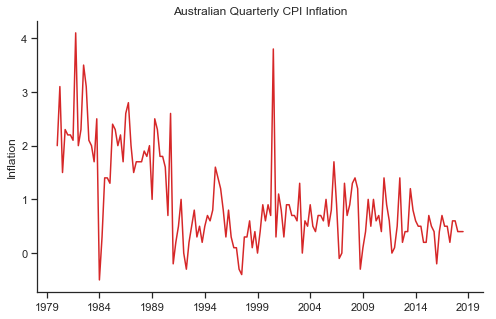

In [6]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [7]:
y.describe().round(2)

count    155.00
mean       0.99
std        0.87
min       -0.50
25%        0.40
50%        0.70
75%        1.50
max        4.10
Name: Inflation, dtype: float64

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [8]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q4    0.4
2019Q1    0.4
2019Q2    0.4
2019Q3    0.4
Freq: Q-DEC, dtype: float64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [9]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

0.785

Using the formulas from the lecture, the interval forecasts are as below. 

In [10]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q4,-1.138,1.938
2019Q1,-1.775,2.575
2019Q2,-2.264,3.064
2019Q3,-2.676,3.476


## Simple exponential smoothing

The exponential smoothing functions are in the <TT>forecast</TT> module from the LMS. 

In [11]:
import forecast # you need to download the forecast.py file from the LMS

ses=forecast.ses(y)
ses.fit()
fitted=pd.Series(ses.smooth(), index=y.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.288 (0.071) 

 In-sample fit:
 MSE               0.411
 Log-likelihood   -150.996
 AIC               307.993
 BIC               317.123


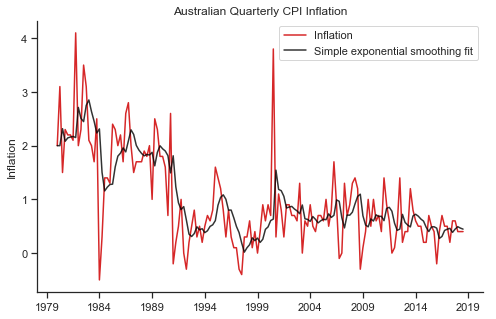

In [12]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red, label='Inflation')
fitted.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tools import eval_measures 
model_ses = SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
alpha_ses = model_ses.model.params['smoothing_level']
mse_ses = eval_measures.mse(y,fitted_ses)
# loglik_ses = model_ses.model.loglike(model_ses.model.params) #NotImplementedError
loglik_ses = 'N/A'
aic_ses = model_ses.aic
bic_ses = model_ses.bic
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_ses))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))
print(' Log-likelihood    %s' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))


 Smoothing parameter: alpha  0.283
 In-sample fit:
 MSE               0.410
 Log-likelihood    N/A
 AIC               -134.300
 BIC               -128.213


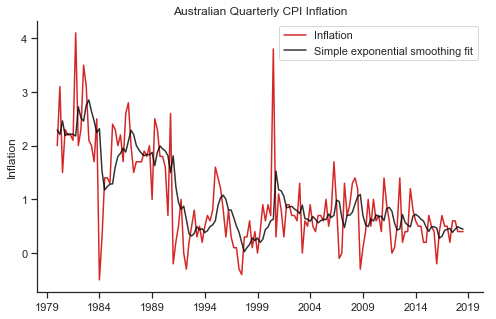

In [37]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residula ACF.
3. Residual distribution plots.

We compute the residulas as follows.

In [17]:
resid=y-fitted

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

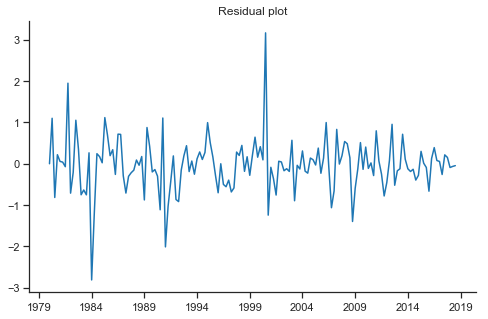

In [18]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

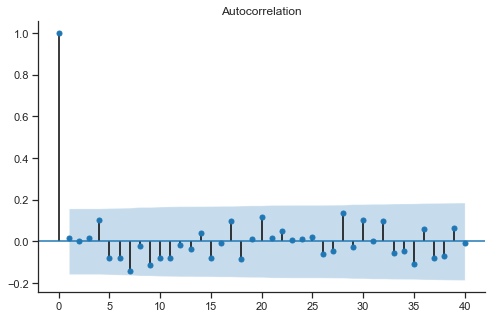

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

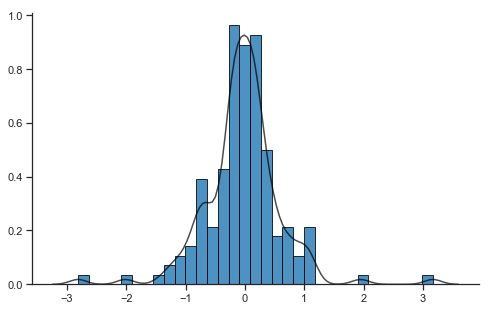

In [20]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

Based on this finding, I use only the post-80s data for the rest of the analysis, which will probably lead to a more relevant estimate of the variance of the errors for forecasting inflation. 

In [21]:
#y=y['1991':]
ses=forecast.ses(y)
ses.fit()
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.288 (0.071) 

 In-sample fit:
 MSE               0.411
 Log-likelihood   -150.996
 AIC               307.993
 BIC               317.123


## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [22]:
# Real time forecasting - use it as a template

validation=y['2004Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2004Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

We find that simple exponential smoothing generates more accurate forecasts. 

In [23]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
RW,0.518,0.056
SES,0.478,0.053


## Forecast

We use a fan chart to report our final forecast. For now, the prediction interval is based on the normal distribution, even though we saw that this is not a good assumption for this data. 

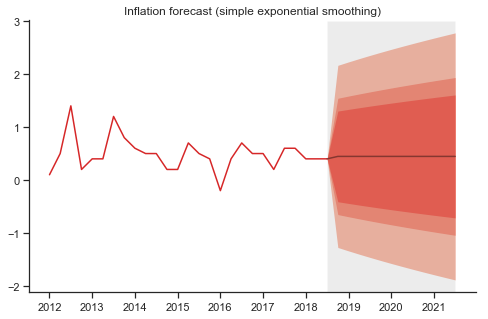

In [24]:
h=12

model = ses

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')

pred=pd.Series(model.forecast(h), index=test)

intv1=pd.DataFrame(model.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(model.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(model.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Inflation forecast (simple exponential smoothing)')

sns.despine()
plt.show()